import numpy and pandas 

In [50]:
import numpy as np
import pandas as pd

import dataset

In [51]:
df = pd.read_csv('mytips.csv',sep = '\t')


In [52]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
total_bill    244 non-null float64
tip           244 non-null float64
sex           244 non-null object
smoker        244 non-null object
day           244 non-null object
time          244 non-null object
size          244 non-null int64
dtypes: float64(2), int64(1), object(4)
memory usage: 13.4+ KB


create target and features

In [54]:
y = df['tip']#target 
X = df.drop('tip', axis=1)# features

transform categorical data to numerical 

In [55]:
codes, labels = pd.factorize(df['day'])# factorize labels to codes
print('Codes:  ', codes[::10], end='\n\n')
print('Labels: ', labels[codes[::10]])

Codes:   [0 0 1 1 1 0 1 1 2 3 3 1 2 2 2 0 0 1 0 0 2 1 3 1 1]

Labels:  Index(['Sun', 'Sun', 'Sat', 'Sat', 'Sat', 'Sun', 'Sat', 'Sat', 'Thur', 'Fri',
       'Fri', 'Sat', 'Thur', 'Thur', 'Thur', 'Sun', 'Sun', 'Sat', 'Sun', 'Sun',
       'Thur', 'Sat', 'Fri', 'Sat', 'Sat'],
      dtype='object')


create new dataframe by transforming entire categorical data into numerical data

In [56]:
cat_cols = ['sex', 'smoker', 'day', 'time']# new field name 

X_factorized = X.copy()#copy 
X_factorized[cat_cols] = X_factorized[cat_cols].apply(
    lambda x: pd.factorize(x)[0]
)
X_factorized.head()

,total_bill,sex,smoker,day,time,size
0,16.99,0,0,0,0,2
1,10.34,1,0,0,0,3
2,21.01,1,0,0,0,3
3,23.68,1,0,0,0,2
4,24.59,0,0,0,0,4


In [58]:
from sklearn.linear_model import LinearRegression# import linear model
%xmode Plain # plain ,default context, vorbose, this reports the error with different clearity
lm = LinearRegression()
lm.fit(X_factorized, y)

/Users/rivers/anaconda3/lib/python3.6/site-packages/IPython/core/magics/basic.py:371: UserWarning: Error changing user exception modes.
Unrecognized mode in FormattedTB: <Plain# plain ,default context, vorbose, this reports the error with different clearity>
Valid modes: ['Plain', 'Context', 'Verbose']
  (name,sys.exc_info()[1]))


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [59]:
pd.Series(lm.coef_, X_factorized.columns)# get each coefficient 

total_bill    0.094076
sex          -0.029216
smoker       -0.081041
day          -0.007834
time          0.005721
size          0.179367
dtype: float64

In [62]:
from sklearn.cross_validation import train_test_split# train test split

X_train, X_test = train_test_split(X, random_state=0) # random_state = a int, will make train test constant
_, train_order = pd.factorize(X_train['day'])# factor in to numeric data
_, test_order = pd.factorize(X_test['day'])# factor into numeric data

train_order# make sure days in train and test has same order for later prediction

Index(['Sat', 'Thur', 'Sun', 'Fri'], dtype='object')

In [63]:
test_order

Index(['Sat', 'Sun', 'Fri', 'Thur'], dtype='object')

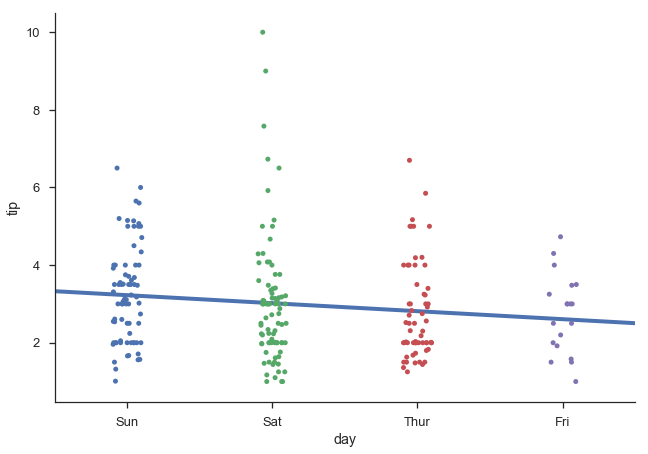

In [80]:
%matplotlib inline
import seaborn as sns

sns.set(style='ticks', context='talk')

# Fit just "tip ~ day", to make plotting easier
lm = LinearRegression()
lm.fit(X_factorized[['day']], y)
b0, b1 = lm.intercept_, lm.coef_.ravel()[0]

ax = sns.stripplot('day', 'tip', data=df, jitter=1)# similar to ggplot2, choose dataset and its field 
xlim = ax.get_xlim()
xx = np.linspace(*xlim, 2)#Return evenly spaced numbers over a specified interval.
ax.plot(xx, [3.2245 + b1 * xx[0], b0 + b1 * xx[1]], lw=4)#plot from (-0.5,y1), to (- 3.5, y2) with line with = 4
sns.despine()

the factorization mathod is inpractical for these type of data

In [81]:
X_dummy = pd.get_dummies(X)#use dummy instead ,pd operate on entire dataframe with numerical data unchanged
X_dummy.head()

,total_bill,size,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch
0,16.99,2,1,0,1,0,0,0,1,0,1,0
1,10.34,3,0,1,1,0,0,0,1,0,1,0
2,21.01,3,0,1,1,0,0,0,1,0,1,0
3,23.68,2,0,1,1,0,0,0,1,0,1,0
4,24.59,4,1,0,1,0,0,0,1,0,1,0


Let's run the linear model again

In [82]:
lm = LinearRegression()
lm.fit(X_dummy, y)

pd.Series(lm.coef_, index=X_dummy.columns)

total_bill     0.094487
size           0.175992
sex_Female     0.016220
sex_Male      -0.016220
smoker_No      0.043204
smoker_Yes    -0.043204
day_Fri        0.077300
day_Sat       -0.044159
day_Sun        0.051819
day_Thur      -0.084960
time_Dinner   -0.034064
time_Lunch     0.034064
dtype: float64

In [83]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso

X_scaled = StandardScaler().fit_transform(X_dummy, y)
X_poly = (PolynomialFeatures(interaction_only=True)
            .fit_transform(X_scaled, y))
model = Lasso(alpha=.5)# set coef to zero for low affecting features
model.fit(X_poly, y)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [84]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(StandardScaler(),
                     PolynomialFeatures(interaction_only=True),
                     Lasso(alpha=.5))
pipe.fit(X_dummy, y)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=True)), ('lasso', Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [85]:
day = df['day'].astype('category').head()
day.head()

0    Sun
1    Sun
2    Sun
3    Sun
4    Sun
Name: day, dtype: category
Categories (4, object): [Fri, Sat, Sun, Thur]

In [86]:
day.cat.categories

Index(['Fri', 'Sat', 'Sun', 'Thur'], dtype='object')

In [87]:
day.cat.ordered

False

In [102]:
from sklearn.base import TransformerMixin

class CategoricalTransformer(TransformerMixin):
    "Converts a set of columns in a DataFrame to categoricals"
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        'Records the categorical information'
        self.cat_map_ = {col: X[col].astype('category').cat
                         for col in self.columns}
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for col in self.columns:
            X[col] = pd.Categorical(X[col],
            categories=self.cat_map_[col].categories,
            ordered=self.cat_map_[col].ordered)
        return X

    def inverse_transform(self, trn, y=None):
        trn = trn.copy()
        trn[self.columns] = trn[self.columns].apply(lambda x: x.astype(object))
        return trn

In [103]:
ct = CategoricalTransformer(columns=['sex', 'smoker', 'day', 'time'])
X_cat = ct.fit_transform(X)
X_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 6 columns):
total_bill    244 non-null float64
sex           244 non-null category
smoker        244 non-null category
day           244 non-null category
time          244 non-null category
size          244 non-null int64
dtypes: category(4), float64(1), int64(1)
memory usage: 4.9 KB


In [104]:
class DummyEncoder(TransformerMixin):

    def fit(self, X, y=None):
        self.columns_ = X.columns
        self.cat_cols_ = X.select_dtypes(include=['category']).columns
        self.non_cat_cols_ = X.columns.drop(self.cat_cols_)
        self.cat_map_ = {col: X[col].cat for col in self.cat_cols_}

        self.cat_blocks_ = {}  # {cat col: slice}
        left = len(self.non_cat_cols_)
        for col in self.cat_cols_:
            right = left + len(self.cat_map_[col].categories)
            self.cat_blocks_[col] = slice(left, right)
            left = right
        return self

    def transform(self, X, y=None):
        return np.asarray(pd.get_dummies(X))

    def inverse_transform(self, trn, y=None):
        numeric = pd.DataFrame(trn[:, :len(self.non_cat_cols_)],
                               columns=self.non_cat_cols_)
        series = []
        for col, slice_ in self.cat_blocks_.items():
            codes = trn[:, slice_].argmax(1)
            cat = self.cat_map_[col]
            cat = pd.Categorical.from_codes(codes,
                                            cat.categories,
                                            cat.ordered)
            series.append(pd.Series(cat, name=col))
        return pd.concat([numeric] + series, axis='columns')[self.columns_]

self = DummyEncoder()
trn = self.fit_transform(X_cat)
trn

array([[ 16.99,   2.  ,   1.  , ...,   0.  ,   1.  ,   0.  ],
       [ 10.34,   3.  ,   0.  , ...,   0.  ,   1.  ,   0.  ],
       [ 21.01,   3.  ,   0.  , ...,   0.  ,   1.  ,   0.  ],
       ..., 
       [ 22.67,   2.  ,   0.  , ...,   0.  ,   1.  ,   0.  ],
       [ 17.82,   2.  ,   0.  , ...,   0.  ,   1.  ,   0.  ],
       [ 18.78,   2.  ,   1.  , ...,   1.  ,   1.  ,   0.  ]])

In [105]:
numeric = pd.DataFrame(trn[:, :len(self.non_cat_cols_)],
                       columns=self.non_cat_cols_)
numeric.head()

,total_bill,size
0,16.99,2.0
1,10.34,3.0
2,21.01,3.0
3,23.68,2.0
4,24.59,4.0


In [106]:
self.cat_blocks_

{'day': slice(6, 10, None),
 'sex': slice(2, 4, None),
 'smoker': slice(4, 6, None),
 'time': slice(10, 12, None)}

In [107]:
trn[:, self.cat_blocks_['day']][:5]

array([[ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.]])

In [108]:
codes = trn[:, self.cat_blocks_['day']].argmax(1)
codes[:5]

array([2, 2, 2, 2, 2])

In [109]:
cat = pd.Categorical.from_codes(codes, self.cat_map_['day'].categories,
                                self.cat_map_['day'].ordered)
cat

[Sun, Sun, Sun, Sun, Sun, ..., Sat, Sat, Sat, Sat, Thur]
Length: 244
Categories (4, object): [Fri, Sat, Sun, Thur]

In [110]:
columns = ['sex', 'smoker', 'day', 'time']
pipe = make_pipeline(CategoricalTransformer(columns), DummyEncoder(), LinearRegression())
pipe.fit(X, y)

Pipeline(steps=[('categoricaltransformer', <__main__.CategoricalTransformer object at 0x113d11940>), ('dummyencoder', <__main__.DummyEncoder object at 0x113d11c88>), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

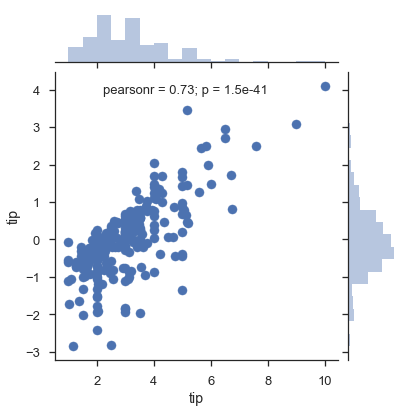

In [111]:
yhat = pipe.predict(X)
sns.jointplot(y, y-yhat)

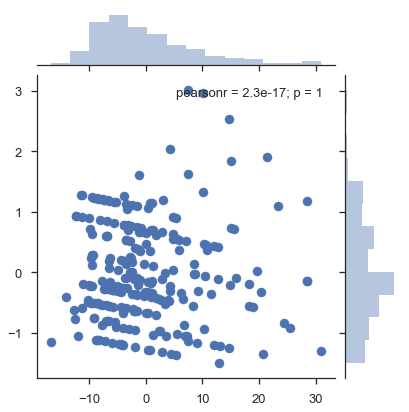

In [112]:
from sklearn.decomposition import PCA

pipe = make_pipeline(CategoricalTransformer(columns), DummyEncoder(), PCA())
trn = pipe.fit_transform(X)
sns.jointplot(trn[:, 0], trn[:, 1]);

In [113]:
pipe.inverse_transform(trn).head()

,total_bill,sex,smoker,day,time,size
0,16.99,Female,No,Sun,Dinner,2.0
1,10.34,Male,No,Sun,Dinner,3.0
2,21.01,Male,No,Sun,Dinner,3.0
3,23.68,Male,No,Sun,Dinner,2.0
4,24.59,Female,No,Sun,Dinner,4.0
